
<a id='aiyagari'></a>
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# The Aiyagari Model

## Contents

- [The Aiyagari Model](#The-Aiyagari-Model)  
  - [Overview](#Overview)  
  - [The Economy](#The-Economy)  
  - [Implementation](#Implementation)  
  - [Exercises](#Exercises)  

In addition to what’s included in base Anaconda, we need to install JAX

## basado y extraido de 



https://python.quantecon.org/aiyagari.html   PYTHON

https://julia.quantecon.org/multi_agent_models/aiyagari.html PYTHON

https://jax.quantecon.org/aiyagari_jax.html  JULIA


## repositiorios
https://quantecon.org/code/

https://github.com/JulienPascal/AiyagariAggregateUncertainty 

https://github.com/QuantEcon/notebook-gallery

In [35]:
#!pip install quantecon jax

## Overview

In this lecture, we describe the structure of a class of models that build on work by Truman Bewley [[Bewley, 1977](https://python.quantecon.org/zreferences.html#id191)].

We begin by discussing an example of a Bewley model due to Rao Aiyagari [[Aiyagari, 1994](https://python.quantecon.org/zreferences.html#id155)].

The model features

- heterogeneous agents  
- a single exogenous vehicle for borrowing and lending  
- limits on amounts individual agents may borrow  


The Aiyagari model has been used to investigate many topics, including

- precautionary savings and the effect of liquidity constraints [[Aiyagari, 1994](https://python.quantecon.org/zreferences.html#id155)]  
- risk sharing and asset pricing [[Heaton and Lucas, 1996](https://python.quantecon.org/zreferences.html#id147)]  
- the shape of the wealth distribution [[Benhabib *et al.*, 2015](https://python.quantecon.org/zreferences.html#id148)]  
- etc., etc., etc.  

### Preliminaries

We use the following imports:

In [1]:
import quantecon as qe
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from typing import NamedTuple
from scipy.optimize import bisect
import time

We will use 64-bit floats with JAX in order to increase precision.

In [4]:
jax.config.update("jax_enable_x64", True)

We will use the following function to compute stationary distributions of stochastic matrices (for a reference to the algorithm, see p. 88 of [Economic Dynamics](https://johnstachurski.net/edtc)).

In [5]:
@jax.jit
def compute_stationary(P):
    n = P.shape[0]
    I = jnp.identity(n)
    O = jnp.ones((n, n))
    A = I - jnp.transpose(P) + O
    return jnp.linalg.solve(A, jnp.ones(n))

### References

The primary reference for this lecture is [[Aiyagari, 1994](https://python.quantecon.org/zreferences.html#id155)].

A textbook treatment is available in chapter 18 of [[Ljungqvist and Sargent, 2018](https://python.quantecon.org/zreferences.html#id200)].

A continuous time version of the model by SeHyoun Ahn and Benjamin Moll can be found [here](https://nbviewer.org/github/QuantEcon/QuantEcon.notebooks/blob/master/aiyagari_continuous_time.ipynb).

## The Economy

### Households

Infinitely lived households / consumers face idiosyncratic income shocks.

A unit interval of  *ex-ante* identical households face a common borrowing constraint.

The savings problem faced by a typical  household is

$$
\max \mathbb E \sum_{t=0}^{\infty} \beta^t u(c_t)
$$

subject to

$$
a_{t+1} + c_t \leq w z_t + (1 + r) a_t
\quad
c_t \geq 0,
\quad \text{and} \quad
a_t \geq -B
$$

where

- $ c_t $ is current consumption  
- $ a_t $ is assets  
- $ z_t $ is an exogenous component of labor income capturing stochastic unemployment risk, etc.  
- $ w $ is a wage rate  
- $ r $ is a net interest rate  
- $ B $ is the maximum amount that the agent is allowed to borrow  


The exogenous process $ \{z_t\} $ follows a finite state Markov chain with given stochastic matrix $ P $.

The wage and interest rate are fixed over time.

In this simple version of the model, households supply labor inelastically because they do not value leisure.

### Firms

Firms produce output by hiring capital and labor.

Firms act competitively and face constant returns to scale.

Since returns to scale are constant, the number of firms does not matter.

Hence we can consider a single (but nonetheless competitive) representative firm.

The firm’s output is

$$
Y = A K^{\alpha} N^{1 - \alpha}
$$

where

- $ A $ and $ \alpha $ are parameters with $ A > 0 $ and $ \alpha \in (0, 1) $  
- $ K $ is aggregate capital  
- $ N $ is total labor supply (which is constant in this simple version of the model)  


The firm’s problem is

$$
\max_{K, N} \left\{ A K^{\alpha} N^{1 - \alpha} - (r + \delta) K - w N \right\}
$$

The parameter $ \delta $ is the depreciation rate.

These parameters are stored in the following namedtuple:

In [6]:
class Firm(NamedTuple):
    A: float = 1.0    # Total factor productivity
    N: float = 1.0    # Total labor supply
    α: float = 0.33   # Capital share
    δ: float = 0.05   # Depreciation rate

From the first-order condition with respect to capital, the firm’s inverse demand for capital is


<a id='equation-aiy-rgk'></a>
$$
r = A \alpha  \left( \frac{N}{K} \right)^{1 - \alpha} - \delta \tag{74.1}
$$

In [7]:
def r_given_k(K, firm):
    """
    Inverse demand curve for capital. The interest rate associated with a
    given demand for capital K.
    """
    A, N, α, δ = firm
    return A * α * (N / K)**(1 - α) - δ

Using this expression and the firm’s first-order condition for labor, we can pin down
the equilibrium wage rate as a function of $ r $ as


<a id='equation-aiy-wgr'></a>
$$
w(r) = A  (1 - \alpha)  (A \alpha / (r + \delta))^{\alpha / (1 - \alpha)} \tag{74.2}
$$

In [8]:
def r_to_w(r, firm):
    """
    Equilibrium wages associated with a given interest rate r.
    """
    A, N, α, δ = firm
    return A * (1 - α) * (A * α / (r + δ))**(α / (1 - α))

### Equilibrium

We construct  a **stationary rational expectations equilibrium (SREE)**.

In such an equilibrium

- prices induce behavior that generates aggregate quantities consistent with the prices  
- aggregate quantities and prices are constant over time  


In more detail, an SREE lists a set of prices, savings and production policies such that

- households want to choose the specified savings policies taking the prices as given  
- firms maximize profits taking the same prices as given  
- the resulting aggregate quantities are consistent with the prices; in particular, the demand for capital equals the supply  
- aggregate quantities (defined as cross-sectional averages) are constant  

## Implementation

Let’s look at how we might compute such an equilibrium in practice.

Below we provide code to solve the household problem, taking $ r $ and $ w $ as fixed.

### Primitives and operators

We will solve the household problem using Howard policy iteration (see Ch 5 of [Dynamic Programming](https://dp.quantecon.org/)).

First we set up a `NamedTuple` to store the parameters that define a household asset accumulation problem, as well as the grids used to solve it

In [9]:
class Household(NamedTuple):
    β: float            # Discount factor
    a_grid: jnp.ndarray # Asset grid
    z_grid: jnp.ndarray # Exogenous states
    Π: jnp.ndarray      # Transition matrix

def create_household(β=0.96,                      # Discount factor
                     Π=[[0.9, 0.1], [0.1, 0.9]],  # Markov chain
                     z_grid=[0.1, 1.0],           # Exogenous states
                     a_min=1e-10, a_max=20,       # Asset grid
                     a_size=200):
    """
    Create a Household namedtuple with custom grids.
    """
    a_grid = jnp.linspace(a_min, a_max, a_size)
    z_grid, Π = map(jnp.array, (z_grid, Π))
    return Household(β=β, a_grid=a_grid, z_grid=z_grid, Π=Π)

For now we assume that $ u(c) = \log(c) $

In [10]:
u = jnp.log

Here’s a namedtuple that stores the wage rate and interest rate with default values

In [11]:
class Prices(NamedTuple):
    r: float = 0.01  # Interest rate
    w: float = 1.0   # Wages

Now we set up a vectorized version of the right-hand side of the Bellman equation (before maximization), which is a 3D array representing

$$
B(a, z, a') = u(wz + (1+r)a - a') + \beta \sum_{z'} v(a', z') \Pi(z, z')
$$

for all $ (a, z, a') $.

In [12]:
@jax.jit
def B(v, household, prices):
    # Unpack
    β, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)
    r, w = prices

    # Compute current consumption as array c[i, j, ip]
    a  = jnp.reshape(a_grid, (a_size, 1, 1))    # a[i]   ->  a[i, j, ip]
    z  = jnp.reshape(z_grid, (1, z_size, 1))    # z[j]   ->  z[i, j, ip]
    ap = jnp.reshape(a_grid, (1, 1, a_size))    # ap[ip] -> ap[i, j, ip]
    c = w * z + (1 + r) * a - ap

    # Calculate continuation rewards at all combinations of (a, z, ap)
    v = jnp.reshape(v, (1, 1, a_size, z_size)) # v[ip, jp] -> v[i, j, ip, jp]
    Π = jnp.reshape(Π, (1, z_size, 1, z_size)) # Π[j, jp]  -> Π[i, j, ip, jp]
    EV = jnp.sum(v * Π, axis=-1)               # sum over last index jp

    # Compute the right-hand side of the Bellman equation
    return jnp.where(c > 0, u(c) + β * EV, -jnp.inf)

The next function computes greedy policies

In [14]:
@jax.jit
def get_greedy(v, household, prices):
    """
    Computes a v-greedy policy σ, returned as a set of indices. If 
    σ[i, j] equals ip, then a_grid[ip] is the maximizer at i, j.
    """
    # argmax over ap
    return jnp.argmax(B(v, household, prices), axis=-1)

The following function computes the array $ r_{\sigma} $ which gives current rewards given policy $ \sigma $

In [15]:
@jax.jit
def compute_r_σ(σ, household, prices):
    """
    Compute current rewards at each i, j under policy σ. In particular,

        r_σ[i, j] = u((1 + r)a[i] + wz[j] - a'[ip])

    when ip = σ[i, j].
    """
    # Unpack
    β, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)
    r, w = prices

    # Compute r_σ[i, j]
    a = jnp.reshape(a_grid, (a_size, 1))
    z = jnp.reshape(z_grid, (1, z_size))
    ap = a_grid[σ]
    c = (1 + r) * a + w * z - ap
    r_σ = u(c)

    return r_σ

The value $ v_{\sigma} $ of a policy $ \sigma $ is defined as

$$
v_{\sigma} = (I - \beta P_{\sigma})^{-1} r_{\sigma}
$$

(See Ch 5 of [Dynamic Programming](https://dp.quantecon.org/) for notation and background on Howard policy iteration.)

To compute this vector, we set up the linear map $ v \rightarrow R_{\sigma} v $, where $ R_{\sigma} := I - \beta P_{\sigma} $.

This map can be expressed as

$$
(R_{\sigma} v)(a, z) = v(a, z) - \beta \sum_{z'} v(\sigma(a, z), z') \Pi(z, z')
$$

(Notice that $ R_\sigma $ is expressed as a linear operator rather than a matrix—this is much easier and cleaner to code, and also exploits sparsity.)

In [16]:
@jax.jit
def R_σ(v, σ, household):
    # Unpack
    β, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)

    # Set up the array v[σ[i, j], jp]
    zp_idx = jnp.arange(z_size)
    zp_idx = jnp.reshape(zp_idx, (1, 1, z_size))
    σ = jnp.reshape(σ, (a_size, z_size, 1))
    V = v[σ, zp_idx]
    
    # Expand Π[j, jp] to Π[i, j, jp]
    Π = jnp.reshape(Π, (1, z_size, z_size))
    
    # Compute and return v[i, j] - β Σ_jp v[σ[i, j], jp] * Π[j, jp]
    return v - β * jnp.sum(V * Π, axis=-1)

The next function computes the lifetime value of a given policy

In [17]:
@jax.jit
def get_value(σ, household, prices):
    """
    Get the lifetime value of policy σ by computing

        v_σ = R_σ^{-1} r_σ
    """
    r_σ = compute_r_σ(σ, household, prices)
    
    # Reduce R_σ to a function in v
    _R_σ = lambda v: R_σ(v, σ, household)

    # Compute v_σ = R_σ^{-1} r_σ using an iterative routine.
    return jax.scipy.sparse.linalg.bicgstab(_R_σ, r_σ)[0]

Here’s the Howard policy iteration

In [18]:
def howard_policy_iteration(household, prices,
                            tol=1e-4, max_iter=10_000, verbose=False):
    """
    Howard policy iteration routine.
    """
    β, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)
    σ = jnp.zeros((a_size, z_size), dtype=int)
    
    v_σ = get_value(σ, household, prices)
    i = 0
    error = tol + 1
    while error > tol and i < max_iter:
        σ_new = get_greedy(v_σ, household, prices)
        v_σ_new = get_value(σ_new, household, prices)
        error = jnp.max(jnp.abs(v_σ_new - v_σ))
        σ = σ_new
        v_σ = v_σ_new
        i = i + 1
        if verbose:
            print(f"iteration {i} with error {error}.")
    return σ

As a first example of what we can do, let’s compute and plot an optimal accumulation policy at fixed prices

In [19]:
# Create an instance of Household
household = create_household()
prices = Prices()

r, w = prices
print(f"Interest rate: {r}, Wage: {w}")

Interest rate: 0.01, Wage: 1.0


In [20]:
with qe.Timer():
    σ_star = howard_policy_iteration(
        household, prices, verbose=True).block_until_ready()

iteration 1 with error 11.366688568891618.
iteration 2 with error 9.574747131033332.
iteration 3 with error 3.965394170260123.
iteration 4 with error 1.1207044759289557.
iteration 5 with error 0.25239961968392777.
iteration 6 with error 0.12172324653672995.
iteration 7 with error 0.04339446620777743.
iteration 8 with error 0.012133989584434346.
iteration 9 with error 0.0058242366512129.
iteration 10 with error 0.002853445469376936.
iteration 11 with error 0.0015971311103726293.
iteration 12 with error 0.00047368709217376903.
iteration 13 with error 0.0.
0.67 seconds elapsed


The next plot shows asset accumulation policies at different values of the exogenous state

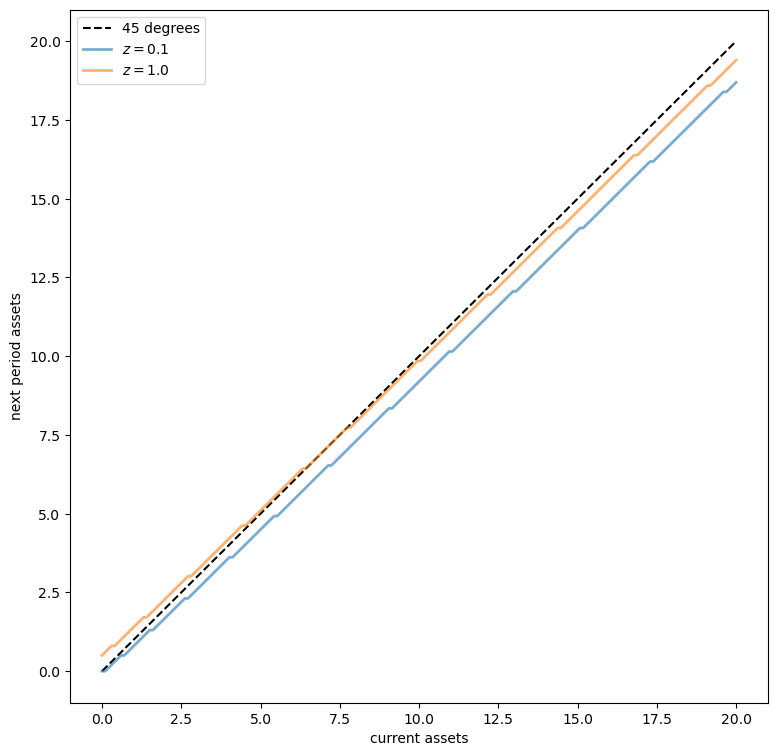

In [21]:
β, a_grid, z_grid, Π = household

fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(a_grid, a_grid, 'k--', label="45 degrees")  
for j, z in enumerate(z_grid):
    lb = f'$z = {z:.2}$'
    policy_vals = a_grid[σ_star[:, j]]
    ax.plot(a_grid, policy_vals, lw=2, alpha=0.6, label=lb)
    ax.set_xlabel('current assets')
    ax.set_ylabel('next period assets')
ax.legend(loc='upper left')
plt.show()

The plot shows asset accumulation policies at different values of the exogenous state.

### Capital supply

To start thinking about equilibrium, we need to know how much capital households supply at a given interest rate $ r $.

This quantity can be calculated by taking the stationary distribution of assets under the optimal policy and computing the mean.

The next function computes the stationary distribution for a given policy $ \sigma $ via the following steps:

- Compute the stationary distribution $ \psi = (\psi(a, z)) $ of $ P_{\sigma} $, which defines the Markov chain of the state $ (a_t, z_t) $ under policy $ \sigma $.  
- Sum out $ z_t $ to get the marginal distribution for $ a_t $.  

In [22]:
@jax.jit
def compute_asset_stationary(σ, household):
    # Unpack
    β, a_grid, z_grid, Π = household
    a_size, z_size = len(a_grid), len(z_grid)

    # Construct P_σ as an array of the form P_σ[i, j, ip, jp]
    ap_idx = jnp.arange(a_size)
    ap_idx = jnp.reshape(ap_idx, (1, 1, a_size, 1))
    σ = jnp.reshape(σ, (a_size, z_size, 1, 1))
    A = jnp.where(σ == ap_idx, 1, 0)
    Π = jnp.reshape(Π, (1, z_size, 1, z_size))
    P_σ = A * Π

    # Reshape P_σ into a matrix
    n = a_size * z_size
    P_σ = jnp.reshape(P_σ, (n, n))

    # Get stationary distribution and reshape back onto [i, j] grid
    ψ = compute_stationary(P_σ)
    ψ = jnp.reshape(ψ, (a_size, z_size))

    # Sum along the rows to get the marginal distribution of assets
    ψ_a = jnp.sum(ψ, axis=1)
    return ψ_a

Let’s give this a test run.

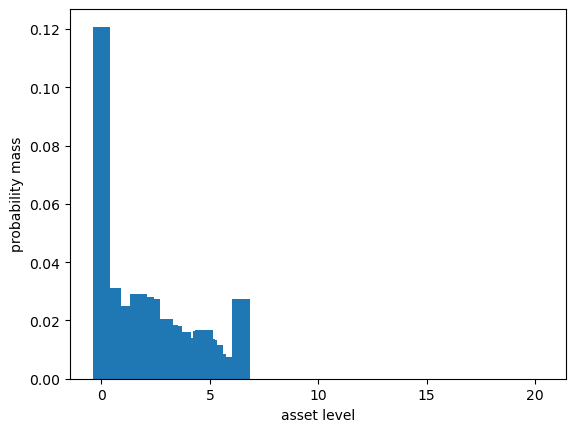

In [23]:
ψ_a = compute_asset_stationary(σ_star, household)

fig, ax = plt.subplots()
ax.bar(household.a_grid, ψ_a)
ax.set_xlabel("asset level")
ax.set_ylabel("probability mass")
plt.show()

The distribution should sum to one:

In [24]:
ψ_a.sum()

Array(1., dtype=float64)

The next function computes aggregate capital supply by households under policy $ \sigma $, given wages and interest rates

In [25]:
def capital_supply(σ, household):
    """
    Induced level of capital stock under the policy, taking r and w as given.
    """
    β, a_grid, z_grid, Π = household
    ψ_a = compute_asset_stationary(σ, household)
    return float(jnp.sum(ψ_a * a_grid))

### Equilibrium

We compute a SREE as follows:

1. Set $ n=0 $ and start with an initial guess $ K_0 $ for aggregate capital.  
1. Determine prices $ r, w $ from the firm decision problem, given $ K_n $.  
1. Compute the optimal savings policy of households given these prices.  
1. Compute aggregate capital $ K_{n+1} $ as the mean of steady-state capital given this savings policy.  
1. If $ K_{n+1} \approx K_n $, stop; otherwise, go to step 2.  


We can write the sequence of operations in steps 2-4 as

$$
K_{n + 1} = G(K_n)
$$

If $ K_{n+1} $ agrees with $ K_n $ then we have a SREE.

In other words, our problem is to find the fixed point of the one-dimensional map $ G $.

Here’s $ G $ expressed as a Python function

In [26]:
def G(K, firm, household):
    # Get prices r, w associated with K
    r = r_given_k(K, firm)
    w = r_to_w(r, firm)

    # Generate a household object with these prices, compute
    # aggregate capital.
    prices = Prices(r=r, w=w)
    σ_star = howard_policy_iteration(household, prices)
    return capital_supply(σ_star, household)

Let’s inspect visually as a first pass

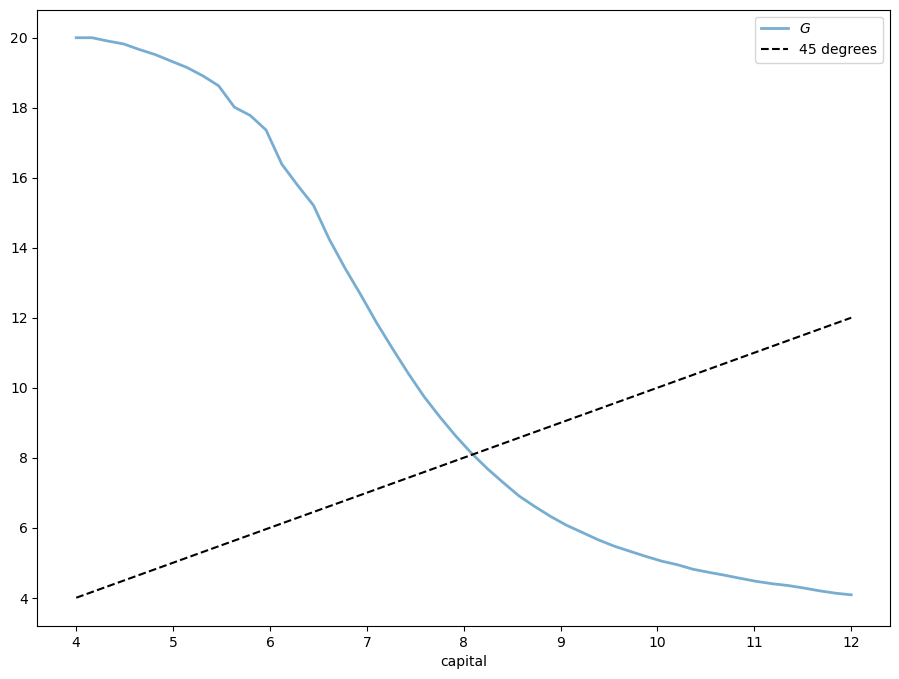

In [27]:
num_points = 50
firm = Firm()
household = create_household()
k_vals = jnp.linspace(4, 12, num_points)
out = [G(k, firm, household) for k in k_vals]

fig, ax = plt.subplots(figsize=(11, 8))
ax.plot(k_vals, out, lw=2, alpha=0.6, label='$G$')
ax.plot(k_vals, k_vals, 'k--', label="45 degrees")
ax.set_xlabel('capital')
ax.legend()
plt.show()

Now let’s compute the equilibrium.

Looking at the figure above, we see that a simple iteration scheme $ K_{n+1} = G(K_n) $ will cycle from high to low values, leading to slow convergence.

As a result, we use a damped iteration scheme of the form

$$
K_{n+1} = \alpha K_n + (1-\alpha) G(K_n)
$$

In [28]:
def compute_equilibrium(firm, household,
                        K0=6, α=0.99, max_iter=1_000, tol=1e-4, 
                        print_skip=10, verbose=False):
    n = 0
    K = K0
    error = tol + 1
    while error > tol and n < max_iter:
        new_K = α * K + (1 - α) * G(K, firm, household)
        error = abs(new_K - K)
        K = new_K
        n += 1
        if verbose and n % print_skip == 0:
            print(f"At iteration {n} with error {error}")
    return K, n

In [29]:
firm = Firm()
household = create_household()
print("\nComputing equilibrium capital stock")
with qe.Timer():
    K_star, n = compute_equilibrium(firm, household, K0=6.0)
print(f"Computed equilibrium {K_star:.5} in {n} iterations")


Computing equilibrium capital stock
24.86 seconds elapsed
Computed equilibrium 8.0918 in 176 iterations


This convergence is not very fast, given how quickly we can solve the household problem.

You can try varying $ \alpha $, but usually this parameter is hard to set a priori.

In the exercises below you will be asked to use bisection instead, which generally performs better.

### Supply and demand curves

We can visualize the equilibrium using supply and demand curves.

The following code draws the aggregate supply and demand curves.

The intersection gives the equilibrium interest rate and capital

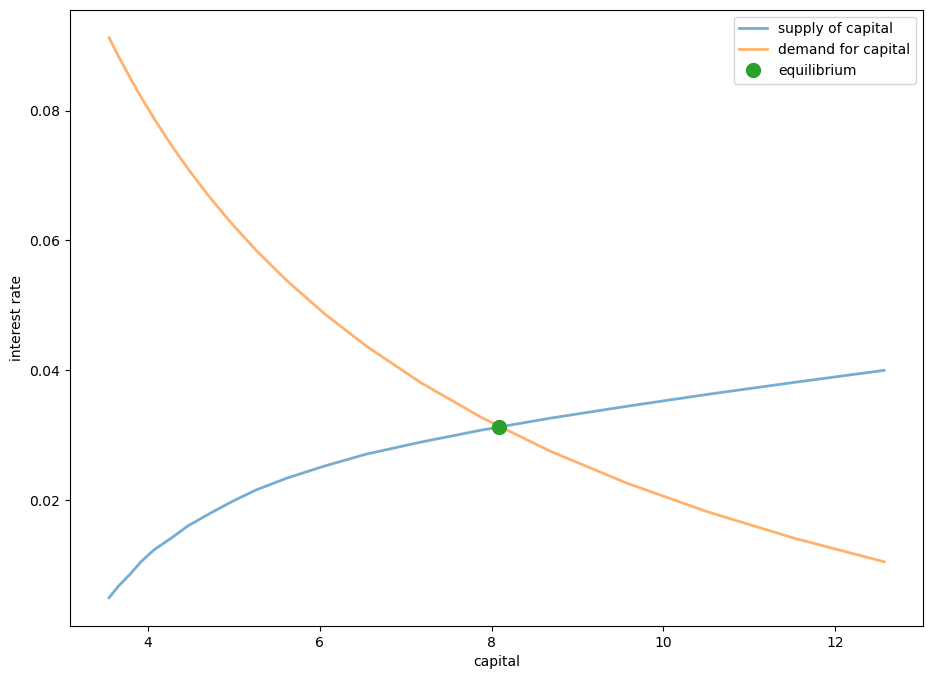

In [30]:
def prices_to_capital_stock(household, r, firm):
    """
    Map prices to the induced level of capital stock.
    """
    w = r_to_w(r, firm)
    prices = Prices(r=r, w=w)

    # Compute the optimal policy
    σ_star = howard_policy_iteration(household, prices)
    
    # Compute capital supply
    return capital_supply(σ_star, household)

# Create a grid of r values to compute demand and supply of capital
num_points = 20
r_vals = jnp.linspace(0.005, 0.04, num_points)

# Compute supply of capital
k_vals = []
for r in r_vals:
    k_vals.append(prices_to_capital_stock(household, r, firm))

# Plot against demand for capital by firms
fig, ax = plt.subplots(figsize=(11, 8))
ax.plot(k_vals, r_vals, lw=2, alpha=0.6, 
        label='supply of capital')
ax.plot(k_vals, r_given_k(
        jnp.array(k_vals), firm), lw=2, alpha=0.6, 
        label='demand for capital')

# Add marker at equilibrium
r_star = r_given_k(K_star, firm)
ax.plot(K_star, r_star, 'o', markersize=10, label='equilibrium')

ax.set_xlabel('capital')
ax.set_ylabel('interest rate')
ax.legend(loc='upper right')

plt.show()

## Exercises

## Exercise 74.1

Write a new version of `compute_equilibrium` that uses `bisect` from `scipy.optimize` instead of damped iteration.

See if you can make it faster than the previous version.

In `bisect`,

- you should set `xtol=1e-4` to have the same error tolerance as the previous version.  
- for the lower and upper bounds of the bisection routine try `a = 1.0` and `b = 20.0`.  

## Solution to[ Exercise 74.1](https://python.quantecon.org/#aiyagari_ex1)

We use bisection to find the zero of the function $ h(k) = k - G(k) $

In [31]:
def compute_equilibrium_bisect(firm, household, a=1.0, b=20.0):
    K = bisect(lambda k: k - G(k, firm, household), a, b, xtol=1e-4)
    return K

firm = Firm()
household = create_household()
print("\nComputing equilibrium capital stock using bisection")
with qe.Timer():
    K_star = compute_equilibrium_bisect(firm, household)
print(f"Computed equilibrium capital stock {K_star:.5}")


Computing equilibrium capital stock using bisection
0.84 seconds elapsed
Computed equilibrium capital stock 8.0938


The bisection method is faster than the damped iteration scheme.

## Exercise 74.2

Show how equilibrium capital stock changes with $ \beta $.

Use the following values of $ \beta $ and plot the relationship you find.

In [32]:
β_vals = jnp.linspace(0.94, 0.98, 20)

## Solution to[ Exercise 74.2](https://python.quantecon.org/#aiyagari_ex2)

Computed equilibrium 6.006 at β = 0.94
Computed equilibrium 6.186 at β = 0.9421052631578948
Computed equilibrium 6.379 at β = 0.9442105263157894
Computed equilibrium 6.577 at β = 0.9463157894736841
Computed equilibrium 6.786 at β = 0.9484210526315789
Computed equilibrium 7.005 at β = 0.9505263157894737
Computed equilibrium 7.226 at β = 0.9526315789473684
Computed equilibrium 7.461 at β = 0.9547368421052631
Computed equilibrium 7.709 at β = 0.9568421052631578
Computed equilibrium 7.966 at β = 0.9589473684210527
Computed equilibrium 8.231 at β = 0.9610526315789473
Computed equilibrium 8.499 at β = 0.9631578947368421
Computed equilibrium 8.787 at β = 0.9652631578947368
Computed equilibrium 9.076 at β = 0.9673684210526315
Computed equilibrium 9.378 at β = 0.9694736842105263
Computed equilibrium 9.687 at β = 0.9715789473684211
Computed equilibrium 10.0 at β = 0.9736842105263158
Computed equilibrium 10.34 at β = 0.9757894736842105
Computed equilibrium 10.67 at β = 0.9778947368421053
Computed

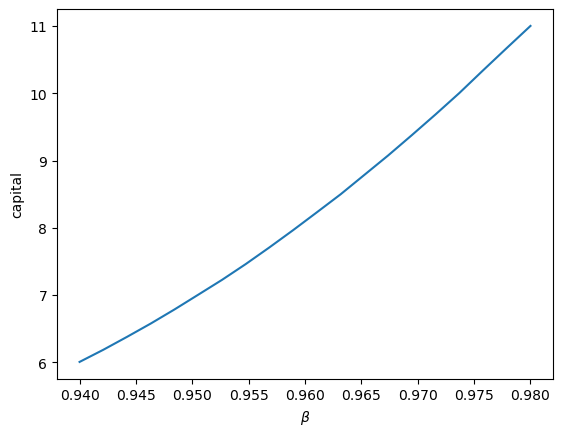

In [33]:
K_vals = []
K = 6.0  # initial guess

for β in β_vals:
    household = create_household(β=β)
    K = compute_equilibrium_bisect(firm, household, 0.5 * K, 1.5 * K)
    print(f"Computed equilibrium {K:.4} at β = {β}")
    K_vals.append(K)

fig, ax = plt.subplots()
ax.plot(β_vals, K_vals, ms=2)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel('capital')
plt.show()